In [ ]:
pip install opencv-python

     |████████████████████████████████| 60.3 MB 9.4 MB/s eta 0:00:011     |████████████████████████████████| 60.1 MB 9.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/My Drive/Leaf_outlines/"

In [4]:
training_data = []
ground_truth = []
for img in os.listdir(path):
    pic = cv2.imread(os.path.join(path,img))
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(256,256))
    training_data.append([pic])
    ground_truth.append(img[0:4])

In [ ]:
saved = np.load(os.path.join(path, 'leaf_images.npy'))

In [5]:
ground_truth[0]

'Pnit'

In [6]:
#Need to make integers for to_categorical later, ignoring pfii because it will merge with Pfoe later
d = {}
counter = 0
for i in ground_truth:
    if i[:4] == 'Pfii':
        continue
    elif i not in d.keys():
        d[i] = counter
        counter += 1
    else:
        continue
d

{'Pact': 37,
 'Pala': 38,
 'Pame': 39,
 'Pbif': 24,
 'Pcae': 25,
 'Pcap': 26,
 'Pcin': 27,
 'Pcoc': 28,
 'Pcor': 29,
 'Pcri': 30,
 'Pedm': 31,
 'Pedu': 32,
 'Pfoe': 33,
 'Pgal': 34,
 'Pgib': 35,
 'Pgra': 36,
 'Phat': 12,
 'Pker': 13,
 'Plig': 14,
 'Pmaf': 15,
 'Pmal': 16,
 'Pmic': 17,
 'Pmie': 18,
 'Pmin': 19,
 'Pmis': 20,
 'Pmol': 21,
 'Pmor': 22,
 'Pmuc': 23,
 'Pnit': 0,
 'Porg': 1,
 'Ppoh': 2,
 'Prac': 3,
 'Prub': 4,
 'Pset': 5,
 'Psid': 6,
 'Psub': 7,
 'Pten': 8,
 'Ptlo': 9,
 'Ptri': 10,
 'Pvil': 11}

In [ ]:
np.save(os.path.join(path,'leaf_images'),np.array(training_data))

In [ ]:
np.save(os.path.join(path,'leaf_truths'),np.array(ground_truth))

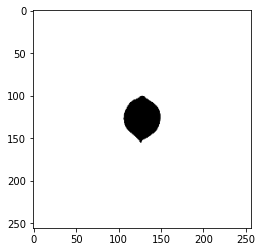

In [7]:
plt.imshow(np.array(training_data[0]).reshape(256,256,3))

In [8]:
import pandas as pd

In [9]:
data = {'image': training_data, 'species': ground_truth}
df = pd.DataFrame(data=data)

In [10]:
'''in read.me of original data, Pfii and Pfoe both represent the same
    species, relabelling to reflect this'''                   
df.species.replace({'Pfii': 'Pfoe'}, inplace=True)                          

In [11]:
#rep#54lacing species name with integer value for later conversion to categoricals
df.species.replace(d, inplace=True)    

In [12]:
df.species.max()

39

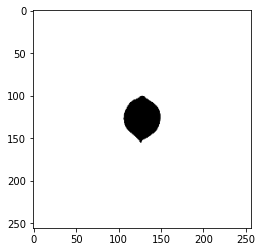

In [14]:
plt.imshow(np.array(df.image[0]).reshape(256,256,3))

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


X_vals, y_vals = np.array(training_data), df.species.astype(np.int64)

# 28x28 images, with grey scale pixel strengths repeated across 3 channels for color representation
X_vals = X_vals.reshape((-1,256,256,3)) 
### REPEAT VALUES ACROSS 2 ADDITIONAL CHANNELS

X_train, X_test, y_train, y_test = (train_test_split(X_vals, y_vals, 
                                                     test_size = .2, random_state = 42))

# 2D (one-hot encoded) representation of multiclass target 
y_train_cat = to_categorical(y_train)

In [ ]:
y_train_cat.shape

(2635, 40)

In [ ]:
y_vals[345]

40

In [ ]:
a = pd.get_dummies(df.species)
a.shape

(3294, 40)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
'''
 In this network structure, note that we follow the typical CNN heuristic of 
 gradually reducing width and height dimenions over time with max pooling
 (typically by a factor of 2), but increasing the filter depth dimension 
 to find increasingly specific patterns. These models are typically compromised 
 of a series of convolutional blocks followed by a flattening operation and 
 a series of fully connected layers at the terminus.
'''

NN = Sequential()

NN.add(InputLayer(input_shape=X_train.shape[1:]))

# Conv block 1.  You can add more conv steps to
# each block to increase model capacity.
NN.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Conv block 2 - note we increase filter dimension as we move
# further into the network. You can add more conv steps to
# each block to increase model capacity.
NN.add(Conv2D(filters=60, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Conv block 3 - The conv blocks should be ended with either a flatten
# layer or a global pooling layer. These transform the 2D layers to 1D
# to match the following dense layers.
NN.add(Conv2D(filters=90, kernel_size=3, activation='relu', padding='same'))

NN.add(GlobalAveragePooling2D())

# Fully connected block - flattening followed by dense and output layers
NN.add(Flatten())
NN.add(Dense(80, activation='relu'))
NN.add(Dense(40, activation='softmax'))  # 40 target classes

NN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
NN.summary()
NN.fit(X_train, y_train_cat, epochs=100, verbose=1, validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])  # track progress as we fit

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 30)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 60)      16260     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 60)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 90)        48690     
                                                                 
 global_average_pooling2d (G  (None, 90)               0

In [ ]:
from sklearn.metrics import accuracy_score

preds = np.argmax(NN.predict(X_test), axis=1)
accuracy_score(y_test, preds)


0.6312594840667678

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lr_confusion = confusion_matrix(y_test, preds)
lr_confusion

sns.set(rc={'figure.figsize':(10,7)})
sns.heatmap(lr_confusion, cmap=plt.cm.Blues,fmt='d', square=True,);

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('confusion matrix')

We have a basic model up and running that demonstrates learning over the epochs, but also seeing some serious overfitting.  First step will be to adjust the architecture via transfer learning and see if a new architecture will improve performance.

In [ ]:
from tensorflow.keras.applications import mobilenet_v2

base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=(80, 80, 3),
    include_top=False)  

base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(80, 80, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(units=80, activation = 'relu')(x)

outputs = keras.layers.Dense(units=40, activation = 'softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
model.summary()
model.fit(X_train, y_train_cat, epochs=100, verbose=1, validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])  # track progress as we fit

mobilenetV2 performed worse than the base model, will try a more robust model, Xception

In [36]:
from tensorflow.keras.applications import Xception
path='/content/models/mnist.79-1.45.hdf5'
base_model = Xception(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False)  

base_model.trainable = True

In [37]:
inputs = keras.Input(shape=(256, 256, 3))

x = base_model(inputs, training=True)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(units=80, activation = 'relu')(x)

outputs = keras.layers.Dense(units=40, activation = 'softmax')(x)
model = keras.Model(inputs, outputs)

In [38]:
#training once to create starting weights
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
model.summary()
model.fit(X_train, y_train_cat, epochs=100, verbose=1, validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])  # track progress as we fit

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 80)                163920    
                                                                 
 dense_15 (Dense)            (None, 40)                3240      
                                                                 
Total params: 21,028,640
Trainable params: 20,974,112
Non-trainable params: 54,528
__________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


62/62 [==============================] - 118s 2s/step - loss: 2.7643 - accuracy: 0.2586 - val_loss: 1.9690 - val_accuracy: 0.4158
Epoch 2/100
62/62 [==============================] - 112s 2s/step - loss: 1.6758 - accuracy: 0.4873 - val_loss: 1.5764 - val_accuracy: 0.5083
Epoch 3/100
62/62 [==============================] - 112s 2s/step - loss: 1.3170 - accuracy: 0.5876 - val_loss: 1.4972 - val_accuracy: 0.5357
Epoch 4/100
62/62 [==============================] - 112s 2s/step - loss: 1.1064 - accuracy: 0.6478 - val_loss: 1.2971 - val_accuracy: 0.6282
Epoch 5/100
62/62 [==============================] - 111s 2s/step - loss: 0.8763 - accuracy: 0.7039 - val_loss: 1.2553 - val_accuracy: 0.6100
Epoch 6/100
62/62 [==============================] - 110s 2s/step - loss: 0.7920 - accuracy: 0.7348 - val_loss: 1.2592 - val_accuracy: 0.6525
Epoch 7/100
62/62 [==============================] - 112s 2s/step - loss: 0.6798 - accuracy: 0.7702 - val_loss: 1.2506 - val_accuracy: 0.6328
Epoch 8/100
62/62 

In [ ]:
from sklearn.metrics import accuracy_score

preds = np.argmax(NN.predict(X_test), axis=1)
accuracy_score(y_test, preds)

Going back to the base model, and attempting regularization in the dense layer to try and reduce overfitting

In [21]:
from tensorflow.keras import regularizers

NN = Sequential()

NN.add(InputLayer(input_shape=X_train.shape[1:]))


NN.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))

NN.add(MaxPooling2D())


NN.add(Conv2D(filters=60, kernel_size=3, activation='relu', padding='same'))

NN.add(MaxPooling2D())


NN.add(Conv2D(filters=90, kernel_size=3, activation='relu', padding='same'))

NN.add(GlobalAveragePooling2D())


NN.add(Flatten())

NN.add(Dense(80, activation='relu', kernel_regularizer='l2'))#added l2 regularizer here

NN.add(Dense(40, activation='softmax'))  # 40 target classes

NN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
NN.summary()
NN.fit(X_train, y_train_cat, epochs=100, verbose=1, validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])  # track progress as we fit

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 30)      840       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 30)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 60)      16260     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 60)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 90)        48690     
                                                                 
 global_average_pooling2d_3   (None, 90)              

accuracy much lower, setting more patience for callback, adding ReduceLROnPlateau callback

In [20]:
from tensorflow.keras.layers import Dropout

NN = Sequential()

NN.add(InputLayer(input_shape=X_train.shape[1:]))


NN.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))

NN.add(MaxPooling2D())


NN.add(Conv2D(filters=60, kernel_size=3, activation='relu', padding='same'))

NN.add(MaxPooling2D())


NN.add(Conv2D(filters=90, kernel_size=3, activation='relu', padding='same'))

NN.add(GlobalAveragePooling2D())


NN.add(Flatten())

NN.add(Dense(80, activation='relu', kernel_regularizer='l2'))

#NN.add(Dropout(0.05)) #added dropout here

NN.add(Dense(40, activation='softmax'))  # 40 target classes

NN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
NN.summary()
NN.fit(X_train, y_train_cat, epochs=100, verbose=1, validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True),
           keras.callbacks.ReduceLROnPlateau(
               factor=.5,
               patience=3,
               verbose=1),
           keras.callbacks.EarlyStopping(
               patience=8,
               verbose=1,
               restore_best_weights=True)
       ])  # track progress as we fit

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 30)      840       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 30)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 60)      16260     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 60)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 90)        48690     
                                                                 
 global_average_pooling2d_2   (None, 90)              

In [ ]:
from tensorflow.keras.layers import Dropout